In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

In [2]:
# CAMERA CALIBRATION

# find corners
def find_corners(img_list):
    objpoints = []  # 3D
    imgpoints = []  # 2D
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  # create blank grid
    
    for image in img_list:   # for all images, create large array of 3D and 2D points
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return imgpoints, objpoints


# calibrate camera
def calibrate_cam(img, imgpoints, objpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

image_folder = glob.glob("camera_cal/*")

imgpoints, objpoints = find_corners(image_folder)

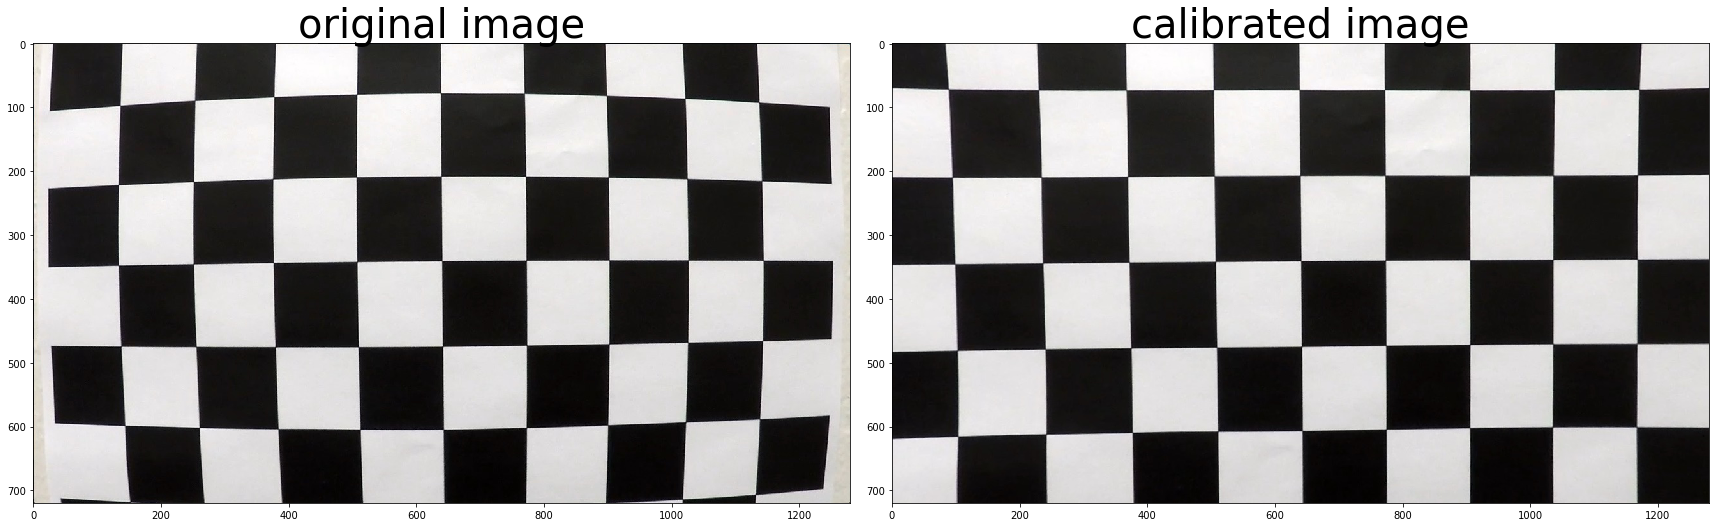

In [3]:
# TESTING CAMERA CALIBRATION

test_img_chessboard = mpimg.imread(image_folder[7])

dst = calibrate_cam(test_img_chessboard, imgpoints, objpoints)

# display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img_chessboard)
ax1.set_title('original image', fontsize=40)

ax2.imshow(dst)
ax2.set_title('calibrated image', fontsize=40)
plt.show()

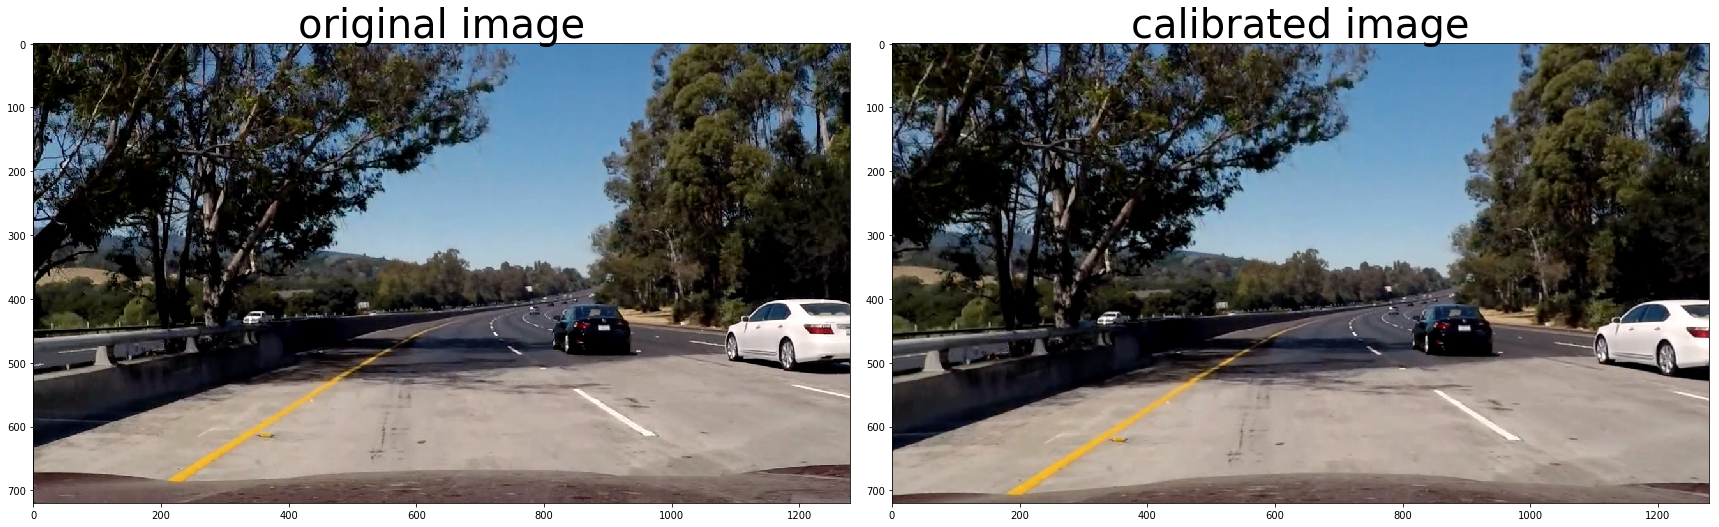

In [4]:
# CALIBRATOIN APPLIED TO ROAD IMAGE

road_image_folder = glob.glob("test_images/*")

orig_image = mpimg.imread(road_image_folder[6])

calibration_test_img = np.copy(orig_image)

calibrated_image = calibrate_cam(calibration_test_img, imgpoints, objpoints)

# display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(calibration_test_img)
ax1.set_title('original image', fontsize=40)

ax2.imshow(calibrated_image)
ax2.set_title('calibrated image', fontsize=40)
plt.show()

In [5]:
# THRESHOLDED BINARY IMAGE (color transforms, gradients, etc.)

def thresh_binary_luv(img, s_thresh=(225, 255), sx_thresh=(45, 140)):
    img = np.copy(img)
    # Convert to Luv color space and separate the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    l_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_transform_luv = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    binary_transform_luv = np.zeros_like(sxbinary)
    binary_transform_luv[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_transform_luv, binary_transform_luv

def thresh_binary_lab(img, s_thresh=(165, 240), sx_thresh=(45, 140)):  # sx_thresh=(45, 140)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel = hls[:,:,2]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_transform_lab = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    binary_transform_lab = np.zeros_like(sxbinary)
    binary_transform_lab[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_transform_lab, binary_transform_lab
    
def thresh_binary_hls(img, s_thresh=(200, 255), sx_thresh=(100, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_transform_hls = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    binary_transform_hls = np.zeros_like(sxbinary)
    binary_transform_hls[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_transform_hls, binary_transform_hls

In [6]:
color_transform_luv, binary_transform_luv = thresh_binary_luv(calibrated_image)

color_transform_hls, binary_transform_hls = thresh_binary_hls(calibrated_image)
    
color_transform_lab, binary_transform_lab = thresh_binary_lab(calibrated_image)

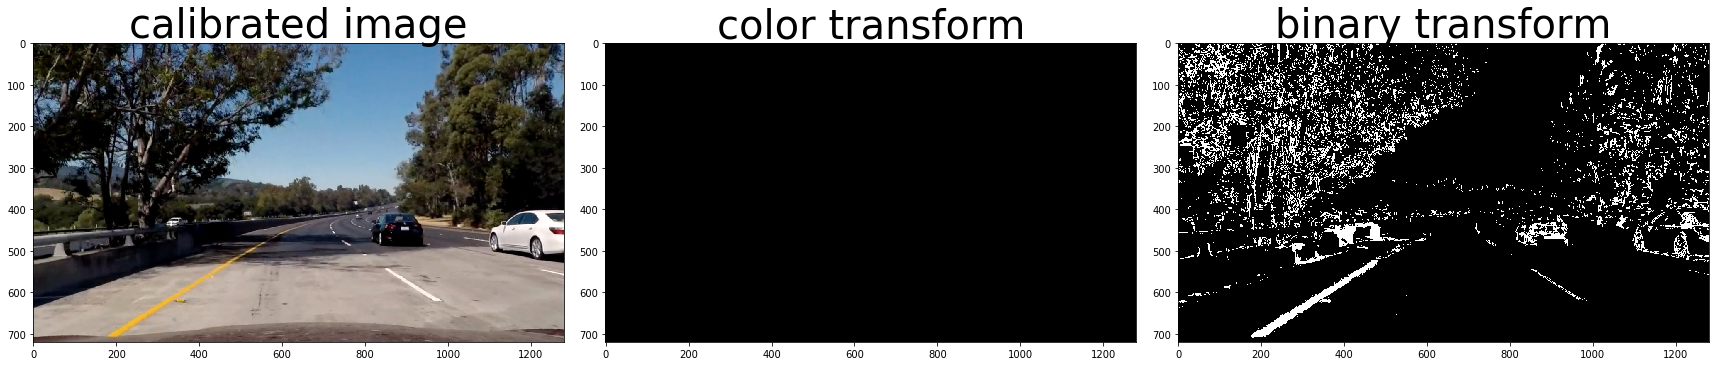

In [7]:
def combine_thresh(img1, img2, img3):
    
    combined_thresh_img = np.zeros_like(img3)
    combined_thresh_img[(img1 == 1) | (img2 == 1) | (img3 == 1)] = 1
    
    return combined_thresh_img

color_transform_combined = combine_thresh(color_transform_luv, color_transform_lab, color_transform_hls)

binary_transform_combined = combine_thresh(binary_transform_luv, binary_transform_lab, binary_transform_hls)

# def combine_thresh(img1, img2):
    
#     combined_thresh_img = np.zeros_like(img2)
#     combined_thresh_img[(img1 == 1) | (img2 == 1)] = 1
    
#     return combined_thresh_img

# color_transform_combined = combine_thresh(color_transform_luv, color_transform_lab)

# binary_transform_combined = combine_thresh(binary_transform_luv, binary_transform_lab)

# display
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibrated_image)
ax1.set_title('calibrated image', fontsize=40)
ax2.imshow(color_transform_combined)
ax2.set_title('color transform', fontsize=40)
ax3.imshow(binary_transform_combined, cmap='gray')
ax3.set_title('binary transform', fontsize=40)
plt.show()

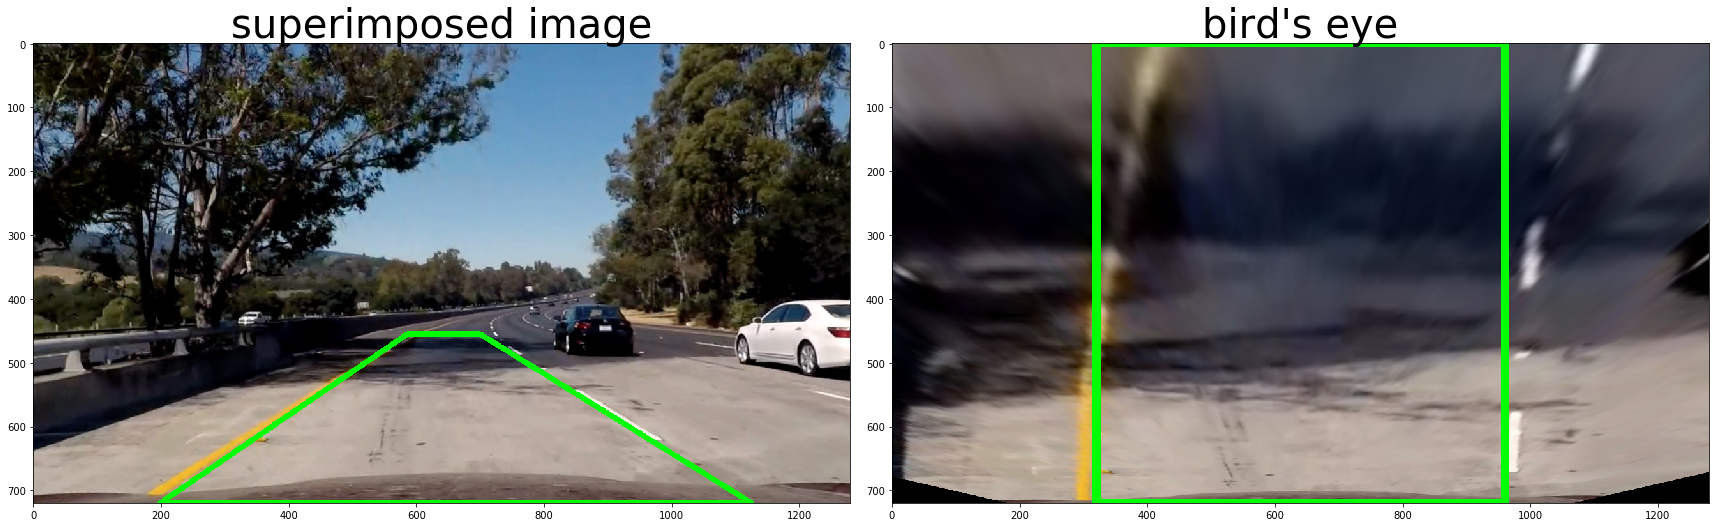

In [8]:
# PERSPECTIVE TRANSFORM

# need to run the perspective transform, display it, then have the same function for each picture (quick) 

def perspective_transform_matrix(img):

    img_size = (img.shape[1], img.shape[0])
    
    corners = np.float32(
        [[(img_size[0] / 2) - 54, img_size[1] / 2 + 95],
        [((img_size[0] / 6) - 15), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 95]])

    warped_corners = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    
    M = cv2.getPerspectiveTransform(corners, warped_corners)

    Minv = cv2.getPerspectiveTransform(warped_corners, corners)
    
    birds_eye = cv2.warpPerspective(img, M, img_size)
    birds_eye_with_box = cv2.polylines(birds_eye, np.int32([warped_corners]), True, (0, 255, 0), 12)

    superimposed_img = cv2.polylines(img, np.int32([corners]), True, (0, 255, 0), 8)
    
    return birds_eye, birds_eye_with_box, superimposed_img, M, Minv

perspective_transform_input = np.copy(calibrated_image)

birds_eye, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(superimposed_img)
ax1.set_title('superimposed image', fontsize=40)
ax2.imshow(birds_eye_with_box)
ax2.set_title('bird\'s eye', fontsize=40)
plt.show()

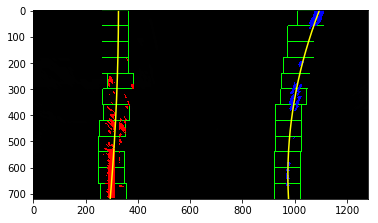

In [9]:
# FIND LANE BOUNDARY

# HISTOGRAM PEAKS

lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(binary_transform_combined)

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(lane_finder_input)


# from lesson:

def find_lane_pixels(lane_finder_input):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(lane_finder_input[lane_finder_input.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((lane_finder_input, lane_finder_input, lane_finder_input))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(lane_finder_input.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_finder_input.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = lane_finder_input.shape[0] - (window+1)*window_height
        win_y_high = lane_finder_input.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(lane_finder_input):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(lane_finder_input)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_finder_input.shape[0]-1, lane_finder_input.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
        
    return out_img, left_fit, right_fit, ploty


out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

plt.imshow(out_img)
plt.show()

720
226575.991027
726406.824535
694.209490984


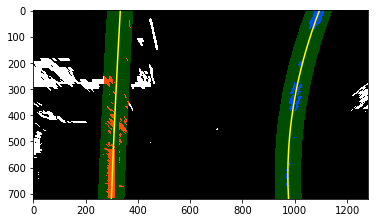

In [10]:
# FIND LANE BOUNDARY (part 2)

# left_fit = np.array([5.88716929e-06, -4.25458630e-02, 3.62626097e+02])
# right_fit = np.array([8.34396471e-06, 3.39224425e-02, 9.15527958e+02])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(lane_finder_input, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = lane_finder_input.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(lane_finder_input.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((lane_finder_input, lane_finder_input, lane_finder_input))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fitx, right_fitx, result = search_around_poly(lane_finder_input, left_fit, right_fit)

print(len(left_fitx))
print(np.sum(left_fitx))

print(np.sum(right_fitx))

print(np.mean(right_fitx) - np.mean(left_fitx))

# View your output
plt.imshow(result)
plt.show()

In [11]:
# DETERMINE CURVATURE OF LANE AND VEHICLE POSITION

out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

# left_fitx, right_fitx, ploty = search_around_poly(lane_finder_input.shape, left_fit, right_fit)

def measure_curvature_real(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_curve = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_curve = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit_curve[1])**2)**1.5) / np.absolute(2*left_fit_curve[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit_curve[1])**2)**1.5) / np.absolute(2*right_fit_curve[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)

print('left curve radius: ', left_curverad, 'm')
print('right curve radius: ', right_curverad, 'm')

left curve radius:  11964.9455624 m
right curve radius:  539.64686309 m


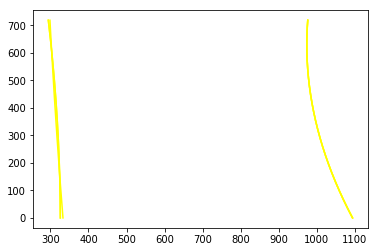

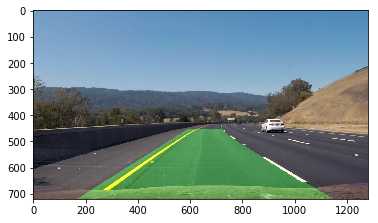

In [12]:
# WARP DETECTED LANE BOUNDARIES BACK ONTO ORIGINAL IMAGE

road_image_folder = glob.glob("test_images/*")

orig_image = mpimg.imread(road_image_folder[4])

calibrated_road_image = calibrate_cam(orig_image, imgpoints, objpoints)

binary_transform_combined_2 = combine_thresh(binary_transform_luv, binary_transform_lab, binary_transform_hls)

# color_transform, binary_transform2 = thresh_binary(calibrated_road_image)

perspective_transform_input = np.copy(binary_transform_combined_2)

lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

left_fitx, right_fitx, result2 = search_around_poly(lane_finder_input, left_fit, right_fit)

def redraw(orig_image, warped, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)    
    
    return result

redrawn_image = redraw(orig_image, binary_transform_combined_2, left_fitx, right_fitx, ploty, Minv)
plt.show()

plt.imshow(redrawn_image)
plt.show()

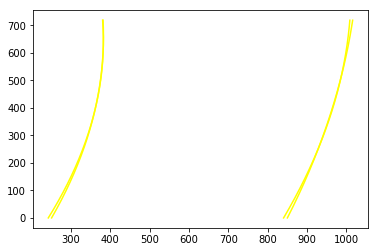

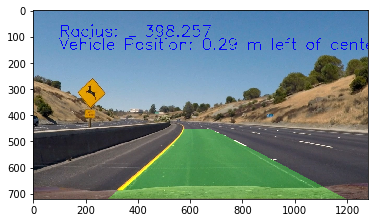

In [13]:
# PIPELINE

road_image_folder = glob.glob("test_images/*")

img = mpimg.imread(road_image_folder[0])

previous_left_fitx = left_fitx
previous_right_fitx = right_fitx
previous_left_curverad = left_curverad
previous_right_curverad = right_curverad


def pipeline(input_image):

    global previous_left_fitx
    global previous_right_fitx
    global previous_left_curverad
    global previous_right_curverad
    
    
    calibrated_road_image = calibrate_cam(input_image, imgpoints, objpoints)
    
    color_transform_luv, binary_transform_luv = thresh_binary_luv(calibrated_road_image)
    
    color_transform_hls, binary_transform_hls = thresh_binary_hls(calibrated_road_image)
    
    color_transform_lab, binary_transform_lab = thresh_binary_lab(calibrated_road_image)
    
    binary_transform_combined_2 = combine_thresh(binary_transform_luv, binary_transform_lab, binary_transform_hls)

    perspective_transform_input = np.copy(binary_transform_combined_2)

    lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

    out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

    left_fitx, right_fitx, result2 = search_around_poly(lane_finder_input, left_fit, right_fit)

    lane_width = np.mean(right_fitx) - np.mean(left_fitx)
    
    lane_width_cls = right_fitx[-1] - left_fitx[-1]
    lane_width_mid = right_fitx[360] - left_fitx[-1]
    lane_width_far = right_fitx[0] - left_fitx[0]
    
    lane_width_arr = [lane_width_cls, lane_width_mid, lane_width_far]
    
    lane_width_avg = np.mean(lane_width_arr)
    
    lane_width_too_much = 60
    
    if ((abs(lane_width_avg - lane_width_cls) > lane_width_too_much) | 
        (abs(lane_width_avg - lane_width_mid) > lane_width_too_much) |
        (abs(lane_width_avg - lane_width_far) > lane_width_too_much)):
        left_fitx = previous_left_fitx
        right_fitx = previous_right_fitx
        print("skipping this frame due to lane width")
    
    
    
#     if ((right_fitx[360] - left_fitx[360]) < 500) | ((right_fitx[360] - left_fitx[360]) > 680):
# #     if (lane_width < 540) | (lane_width > 640):
#         left_fitx = previous_left_fitx
#         right_fitx = previous_right_fitx
#         print("skipping this frame due to lane width")

    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    if (left_curverad > 14000) | (right_curverad > 14000):
        left_curverad = previous_left_curverad
        right_curverad = previous_right_curverad
        print("skipping this frame due to radius")
    
    
    output_image = redraw(input_image, binary_transform_combined_2, left_fitx, right_fitx, ploty, Minv)
    
    previous_left_fitx = left_fitx
    previous_right_fitx = right_fitx
    
    
    
    
    center_lane = input_image.shape[1] / 2 - np.median(left_fitx[-1] + right_fitx[-1]) / 2
    
    rad_delta = (left_curverad - right_curverad) / 2
    
    if (left_curverad > (right_curverad + 200)):
        cv2.putText(output_image, "Radius: R %s" % float('%.6g' % (rad_delta + right_curverad)), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    else:
        cv2.putText(output_image, "Radius: L %s" % float('%.6g' % (rad_delta + left_curverad)), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    if (center_lane < 0):
        center_lane = np.abs(center_lane) * 3.7 / 700 # meters per pixel in x dimension
        cv2.putText(output_image, "Vehicle Position: %s m left of center" % float('%.3g' % (center_lane)), (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    else:
        center_lane = center_lane * 3.7 / 700
        cv2.putText(output_image, "Vehicle Position: %s m left of center" % float('%.3g' % (center_lane)), (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

    previous_left_curverad = left_curverad
    previous_right_curverad = right_curverad
        
    return output_image

pipeline_result = pipeline(img)

plt.show()
plt.imshow(pipeline_result)
plt.show()

In [14]:
# CREATE VIDEO AND SAVE

from moviepy.editor import VideoFileClip

white_output = 'output_images/project_video_processed.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output_images/project_video_processed.mp4
[MoviePy] Writing video output_images/project_video_processed.mp4


  5%|▍         | 62/1261 [00:43<13:52,  1.44it/s]

skipping this frame due to lane width


  5%|▍         | 63/1261 [00:43<13:57,  1.43it/s]

skipping this frame due to lane width


  5%|▌         | 64/1261 [00:44<14:00,  1.42it/s]

skipping this frame due to lane width


  5%|▌         | 65/1261 [00:45<14:09,  1.41it/s]

skipping this frame due to lane width


  5%|▌         | 66/1261 [00:45<14:06,  1.41it/s]

skipping this frame due to lane width


  7%|▋         | 90/1261 [01:02<13:41,  1.42it/s]

skipping this frame due to lane width


 15%|█▍        | 184/1261 [02:08<12:44,  1.41it/s]

skipping this frame due to lane width


 15%|█▍        | 185/1261 [02:09<12:40,  1.41it/s]

skipping this frame due to lane width


 15%|█▍        | 186/1261 [02:10<12:44,  1.41it/s]

skipping this frame due to lane width


 15%|█▍        | 187/1261 [02:11<12:41,  1.41it/s]

skipping this frame due to lane width


 15%|█▍        | 188/1261 [02:11<12:41,  1.41it/s]

skipping this frame due to lane width


 15%|█▍        | 189/1261 [02:12<12:37,  1.41it/s]

skipping this frame due to lane width


 15%|█▌        | 190/1261 [02:13<12:31,  1.42it/s]

skipping this frame due to lane width


 15%|█▌        | 191/1261 [02:13<12:35,  1.42it/s]

skipping this frame due to lane width


 15%|█▌        | 192/1261 [02:14<12:37,  1.41it/s]

skipping this frame due to lane width


 15%|█▌        | 193/1261 [02:15<12:32,  1.42it/s]

skipping this frame due to lane width


 15%|█▌        | 194/1261 [02:15<12:28,  1.43it/s]

skipping this frame due to lane width


 15%|█▌        | 195/1261 [02:16<12:23,  1.43it/s]

skipping this frame due to lane width


 16%|█▋        | 207/1261 [02:24<12:09,  1.45it/s]

skipping this frame due to lane width


 20%|█▉        | 248/1261 [02:53<11:41,  1.44it/s]

skipping this frame due to lane width


 20%|█▉        | 250/1261 [02:54<11:43,  1.44it/s]

skipping this frame due to lane width


 25%|██▍       | 310/1261 [03:36<11:01,  1.44it/s]

skipping this frame due to radius


 25%|██▍       | 311/1261 [03:37<10:58,  1.44it/s]

skipping this frame due to radius


 25%|██▍       | 312/1261 [03:37<10:56,  1.45it/s]

skipping this frame due to radius


 25%|██▍       | 313/1261 [03:38<10:55,  1.45it/s]

skipping this frame due to lane width
skipping this frame due to radius


 25%|██▍       | 314/1261 [03:39<10:55,  1.44it/s]

skipping this frame due to radius


 25%|██▌       | 317/1261 [03:41<10:53,  1.44it/s]

skipping this frame due to radius


 25%|██▌       | 318/1261 [03:42<10:55,  1.44it/s]

skipping this frame due to radius


 25%|██▌       | 319/1261 [03:42<10:52,  1.44it/s]

skipping this frame due to radius


 25%|██▌       | 320/1261 [03:43<10:51,  1.44it/s]

skipping this frame due to lane width
skipping this frame due to radius


 25%|██▌       | 321/1261 [03:44<10:50,  1.45it/s]

skipping this frame due to lane width
skipping this frame due to radius


 26%|██▌       | 322/1261 [03:44<10:50,  1.44it/s]

skipping this frame due to radius


 26%|██▌       | 323/1261 [03:45<10:49,  1.44it/s]

skipping this frame due to radius


 26%|██▌       | 325/1261 [03:46<10:44,  1.45it/s]

skipping this frame due to radius


 26%|██▌       | 327/1261 [03:48<10:44,  1.45it/s]

skipping this frame due to radius


 26%|██▌       | 330/1261 [03:50<10:45,  1.44it/s]

skipping this frame due to radius


 26%|██▌       | 331/1261 [03:51<10:41,  1.45it/s]

skipping this frame due to radius


 26%|██▋       | 332/1261 [03:51<10:41,  1.45it/s]

skipping this frame due to lane width
skipping this frame due to radius


 26%|██▋       | 333/1261 [03:52<10:40,  1.45it/s]

skipping this frame due to lane width
skipping this frame due to radius


 26%|██▋       | 334/1261 [03:53<10:43,  1.44it/s]

skipping this frame due to lane width
skipping this frame due to radius


 27%|██▋       | 335/1261 [03:53<10:41,  1.44it/s]

skipping this frame due to lane width
skipping this frame due to radius


 27%|██▋       | 336/1261 [03:54<10:41,  1.44it/s]

skipping this frame due to radius


 27%|██▋       | 337/1261 [03:55<10:38,  1.45it/s]

skipping this frame due to radius


 27%|██▋       | 340/1261 [03:57<10:39,  1.44it/s]

skipping this frame due to lane width


 27%|██▋       | 341/1261 [03:57<10:37,  1.44it/s]

skipping this frame due to lane width


 27%|██▋       | 342/1261 [03:58<10:41,  1.43it/s]

skipping this frame due to lane width


 27%|██▋       | 343/1261 [03:59<10:38,  1.44it/s]

skipping this frame due to lane width


 27%|██▋       | 346/1261 [04:01<10:39,  1.43it/s]

skipping this frame due to radius


 28%|██▊       | 347/1261 [04:02<10:36,  1.44it/s]

skipping this frame due to radius


 28%|██▊       | 348/1261 [04:02<10:33,  1.44it/s]

skipping this frame due to radius


 29%|██▊       | 361/1261 [04:11<10:25,  1.44it/s]

skipping this frame due to radius


 29%|██▉       | 369/1261 [04:17<10:23,  1.43it/s]

skipping this frame due to lane width


 29%|██▉       | 371/1261 [04:18<10:21,  1.43it/s]

skipping this frame due to lane width


 30%|██▉       | 375/1261 [04:21<10:11,  1.45it/s]

skipping this frame due to lane width


 30%|██▉       | 376/1261 [04:22<10:10,  1.45it/s]

skipping this frame due to lane width


 30%|██▉       | 377/1261 [04:23<10:13,  1.44it/s]

skipping this frame due to lane width


 30%|██▉       | 378/1261 [04:23<10:14,  1.44it/s]

skipping this frame due to lane width


 30%|███       | 379/1261 [04:24<10:11,  1.44it/s]

skipping this frame due to lane width


 30%|███       | 380/1261 [04:25<10:13,  1.44it/s]

skipping this frame due to lane width


 31%|███       | 390/1261 [04:32<10:12,  1.42it/s]

skipping this frame due to radius


 31%|███       | 391/1261 [04:32<10:07,  1.43it/s]

skipping this frame due to radius


 31%|███       | 392/1261 [04:33<10:09,  1.43it/s]

skipping this frame due to radius


 31%|███▏      | 397/1261 [04:37<10:10,  1.41it/s]

skipping this frame due to radius


 32%|███▏      | 399/1261 [04:38<10:13,  1.40it/s]

skipping this frame due to radius


 32%|███▏      | 403/1261 [04:41<10:01,  1.43it/s]

skipping this frame due to radius


 32%|███▏      | 405/1261 [04:42<09:55,  1.44it/s]

skipping this frame due to radius


 33%|███▎      | 410/1261 [04:46<09:51,  1.44it/s]

skipping this frame due to radius


 35%|███▍      | 437/1261 [05:04<09:37,  1.43it/s]

skipping this frame due to radius


 35%|███▌      | 443/1261 [05:09<09:35,  1.42it/s]

skipping this frame due to radius


 35%|███▌      | 444/1261 [05:09<09:31,  1.43it/s]

skipping this frame due to radius


 36%|███▌      | 448/1261 [05:12<09:45,  1.39it/s]

skipping this frame due to radius


 36%|███▌      | 449/1261 [05:13<09:41,  1.40it/s]

skipping this frame due to radius


 36%|███▌      | 454/1261 [05:16<09:30,  1.41it/s]

skipping this frame due to radius


 36%|███▌      | 456/1261 [05:18<09:25,  1.42it/s]

skipping this frame due to radius


 36%|███▌      | 457/1261 [05:18<09:26,  1.42it/s]

skipping this frame due to radius


 37%|███▋      | 472/1261 [05:29<09:16,  1.42it/s]

skipping this frame due to radius


 38%|███▊      | 473/1261 [05:30<09:14,  1.42it/s]

skipping this frame due to radius


 38%|███▊      | 477/1261 [05:33<09:19,  1.40it/s]

skipping this frame due to radius


 38%|███▊      | 478/1261 [05:33<09:20,  1.40it/s]

skipping this frame due to radius


 38%|███▊      | 479/1261 [05:34<09:22,  1.39it/s]

skipping this frame due to radius


 39%|███▊      | 486/1261 [05:39<09:02,  1.43it/s]

skipping this frame due to radius


 39%|███▊      | 487/1261 [05:40<08:58,  1.44it/s]

skipping this frame due to radius


 39%|███▊      | 488/1261 [05:40<08:56,  1.44it/s]

skipping this frame due to radius


 39%|███▉      | 489/1261 [05:41<08:58,  1.43it/s]

skipping this frame due to radius


 39%|███▉      | 490/1261 [05:42<08:58,  1.43it/s]

skipping this frame due to radius


 39%|███▉      | 493/1261 [05:44<08:51,  1.45it/s]

skipping this frame due to radius


 39%|███▉      | 495/1261 [05:45<08:47,  1.45it/s]

skipping this frame due to radius


 39%|███▉      | 497/1261 [05:47<08:43,  1.46it/s]

skipping this frame due to radius


 39%|███▉      | 498/1261 [05:47<08:45,  1.45it/s]

skipping this frame due to radius


 40%|███▉      | 501/1261 [05:49<08:47,  1.44it/s]

skipping this frame due to radius


 40%|███▉      | 502/1261 [05:50<08:53,  1.42it/s]

skipping this frame due to radius


 40%|████      | 505/1261 [05:52<08:50,  1.43it/s]

skipping this frame due to radius


 40%|████      | 507/1261 [05:54<08:52,  1.42it/s]

skipping this frame due to radius


 40%|████      | 508/1261 [05:54<08:52,  1.41it/s]

skipping this frame due to radius


 41%|████      | 513/1261 [05:58<08:44,  1.43it/s]

skipping this frame due to radius


 41%|████      | 514/1261 [05:58<08:41,  1.43it/s]

skipping this frame due to radius


 41%|████      | 516/1261 [06:00<08:38,  1.44it/s]

skipping this frame due to radius


 41%|████      | 520/1261 [06:03<08:36,  1.44it/s]

skipping this frame due to radius


 41%|████▏     | 521/1261 [06:03<08:31,  1.45it/s]

skipping this frame due to radius


 42%|████▏     | 524/1261 [06:05<08:34,  1.43it/s]

skipping this frame due to radius


 42%|████▏     | 532/1261 [06:11<08:26,  1.44it/s]

skipping this frame due to radius


 42%|████▏     | 533/1261 [06:12<08:23,  1.45it/s]

skipping this frame due to radius


 43%|████▎     | 539/1261 [06:16<08:22,  1.44it/s]

skipping this frame due to radius


 43%|████▎     | 541/1261 [06:17<08:22,  1.43it/s]

skipping this frame due to radius


 43%|████▎     | 542/1261 [06:18<08:25,  1.42it/s]

skipping this frame due to radius


 43%|████▎     | 543/1261 [06:19<08:25,  1.42it/s]

skipping this frame due to radius


 44%|████▍     | 559/1261 [06:30<09:06,  1.28it/s]

skipping this frame due to lane width


 44%|████▍     | 560/1261 [06:31<09:11,  1.27it/s]

skipping this frame due to lane width


 44%|████▍     | 561/1261 [06:32<08:57,  1.30it/s]

skipping this frame due to lane width


 45%|████▍     | 562/1261 [06:33<08:47,  1.33it/s]

skipping this frame due to lane width


 45%|████▍     | 563/1261 [06:33<08:34,  1.36it/s]

skipping this frame due to lane width


 45%|████▍     | 564/1261 [06:34<08:29,  1.37it/s]

skipping this frame due to radius


 45%|████▌     | 568/1261 [06:37<08:09,  1.41it/s]

skipping this frame due to lane width


 46%|████▌     | 580/1261 [06:45<08:00,  1.42it/s]

skipping this frame due to lane width


 46%|████▋     | 585/1261 [06:49<07:48,  1.44it/s]

skipping this frame due to radius


 47%|████▋     | 592/1261 [06:54<07:41,  1.45it/s]

skipping this frame due to lane width


 47%|████▋     | 593/1261 [06:54<07:44,  1.44it/s]

skipping this frame due to lane width


 49%|████▉     | 617/1261 [07:11<07:22,  1.45it/s]

skipping this frame due to lane width


 49%|████▉     | 621/1261 [07:14<07:27,  1.43it/s]

skipping this frame due to lane width


 49%|████▉     | 622/1261 [07:14<07:30,  1.42it/s]

skipping this frame due to lane width


 49%|████▉     | 624/1261 [07:16<07:26,  1.43it/s]

skipping this frame due to lane width


 50%|████▉     | 625/1261 [07:16<07:31,  1.41it/s]

skipping this frame due to lane width


 50%|████▉     | 626/1261 [07:17<07:30,  1.41it/s]

skipping this frame due to lane width


 50%|████▉     | 627/1261 [07:18<07:26,  1.42it/s]

skipping this frame due to lane width


 50%|████▉     | 628/1261 [07:18<07:28,  1.41it/s]

skipping this frame due to lane width


 50%|████▉     | 629/1261 [07:19<07:27,  1.41it/s]

skipping this frame due to lane width


 50%|████▉     | 630/1261 [07:20<07:30,  1.40it/s]

skipping this frame due to lane width


 50%|█████     | 633/1261 [07:22<07:47,  1.34it/s]

skipping this frame due to radius


 50%|█████     | 635/1261 [07:24<07:34,  1.38it/s]

skipping this frame due to lane width


 50%|█████     | 636/1261 [07:24<07:27,  1.40it/s]

skipping this frame due to lane width


 51%|█████     | 637/1261 [07:25<07:28,  1.39it/s]

skipping this frame due to lane width


 51%|█████     | 638/1261 [07:26<07:22,  1.41it/s]

skipping this frame due to lane width


 51%|█████     | 639/1261 [07:26<07:19,  1.41it/s]

skipping this frame due to lane width


 51%|█████     | 640/1261 [07:27<07:20,  1.41it/s]

skipping this frame due to lane width


 56%|█████▌    | 701/1261 [08:11<06:38,  1.40it/s]

skipping this frame due to lane width


 62%|██████▏   | 778/1261 [09:05<05:46,  1.39it/s]

skipping this frame due to lane width


 68%|██████▊   | 855/1261 [10:00<04:51,  1.39it/s]

skipping this frame due to radius


 72%|███████▏  | 904/1261 [10:35<04:09,  1.43it/s]

skipping this frame due to radius


 72%|███████▏  | 905/1261 [10:35<04:09,  1.42it/s]

skipping this frame due to radius


 72%|███████▏  | 906/1261 [10:36<04:08,  1.43it/s]

skipping this frame due to radius


 74%|███████▍  | 930/1261 [10:53<03:52,  1.42it/s]

skipping this frame due to radius


 74%|███████▍  | 936/1261 [10:57<03:47,  1.43it/s]

skipping this frame due to radius


 76%|███████▌  | 961/1261 [11:15<03:30,  1.43it/s]

skipping this frame due to radius


 77%|███████▋  | 972/1261 [11:22<03:20,  1.44it/s]

skipping this frame due to radius


 78%|███████▊  | 986/1261 [11:32<03:12,  1.43it/s]

skipping this frame due to radius


 78%|███████▊  | 987/1261 [11:33<03:12,  1.43it/s]

skipping this frame due to radius


 80%|████████  | 1014/1261 [11:51<02:51,  1.44it/s]

skipping this frame due to lane width


 80%|████████  | 1015/1261 [11:52<02:50,  1.45it/s]

skipping this frame due to lane width


 82%|████████▏ | 1029/1261 [12:02<02:40,  1.44it/s]

skipping this frame due to radius


 82%|████████▏ | 1031/1261 [12:03<02:38,  1.45it/s]

skipping this frame due to lane width


 82%|████████▏ | 1032/1261 [12:04<02:39,  1.43it/s]

skipping this frame due to lane width


 82%|████████▏ | 1033/1261 [12:05<02:38,  1.44it/s]

skipping this frame due to lane width


 82%|████████▏ | 1035/1261 [12:06<02:35,  1.45it/s]

skipping this frame due to lane width


 82%|████████▏ | 1036/1261 [12:07<02:36,  1.44it/s]

skipping this frame due to lane width


 82%|████████▏ | 1037/1261 [12:07<02:35,  1.44it/s]

skipping this frame due to lane width


 82%|████████▏ | 1038/1261 [12:08<02:36,  1.43it/s]

skipping this frame due to lane width


 82%|████████▏ | 1039/1261 [12:09<02:37,  1.41it/s]

skipping this frame due to lane width


 82%|████████▏ | 1040/1261 [12:09<02:35,  1.42it/s]

skipping this frame due to lane width


 83%|████████▎ | 1041/1261 [12:10<02:34,  1.43it/s]

skipping this frame due to lane width


 83%|████████▎ | 1042/1261 [12:11<02:33,  1.43it/s]

skipping this frame due to lane width


 83%|████████▎ | 1043/1261 [12:12<02:33,  1.42it/s]

skipping this frame due to lane width


 83%|████████▎ | 1052/1261 [12:18<02:37,  1.33it/s]

skipping this frame due to radius


 84%|████████▎ | 1053/1261 [12:19<02:33,  1.35it/s]

skipping this frame due to radius


 84%|████████▎ | 1056/1261 [12:21<02:27,  1.39it/s]

skipping this frame due to lane width


 84%|████████▍ | 1057/1261 [12:22<02:25,  1.40it/s]

skipping this frame due to lane width


 84%|████████▍ | 1058/1261 [12:23<02:24,  1.40it/s]

skipping this frame due to lane width


 84%|████████▍ | 1059/1261 [12:23<02:23,  1.41it/s]

skipping this frame due to lane width


 84%|████████▍ | 1060/1261 [12:24<02:22,  1.41it/s]

skipping this frame due to lane width


 84%|████████▍ | 1061/1261 [12:25<02:22,  1.40it/s]

skipping this frame due to lane width


 84%|████████▍ | 1062/1261 [12:26<02:22,  1.39it/s]

skipping this frame due to lane width


 84%|████████▍ | 1063/1261 [12:26<02:21,  1.40it/s]

skipping this frame due to lane width


 85%|████████▍ | 1067/1261 [12:29<02:17,  1.41it/s]

skipping this frame due to radius


 85%|████████▌ | 1074/1261 [12:34<02:12,  1.41it/s]

skipping this frame due to radius


 85%|████████▌ | 1075/1261 [12:35<02:13,  1.40it/s]

skipping this frame due to radius


 91%|█████████▏| 1152/1261 [13:30<01:18,  1.39it/s]

skipping this frame due to radius


 93%|█████████▎| 1173/1261 [13:44<01:01,  1.42it/s]

skipping this frame due to radius


 93%|█████████▎| 1177/1261 [13:47<00:58,  1.43it/s]

skipping this frame due to radius


 98%|█████████▊| 1242/1261 [14:34<00:13,  1.42it/s]

skipping this frame due to radius


 99%|█████████▉| 1248/1261 [14:39<00:09,  1.37it/s]

skipping this frame due to radius


100%|█████████▉| 1255/1261 [14:44<00:04,  1.31it/s]

skipping this frame due to radius


100%|█████████▉| 1258/1261 [14:46<00:02,  1.33it/s]

skipping this frame due to radius


100%|█████████▉| 1259/1261 [14:47<00:01,  1.34it/s]

skipping this frame due to radius


100%|█████████▉| 1260/1261 [14:48<00:00,  1.34it/s]

skipping this frame due to radius


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_processed.mp4 

CPU times: user 20min 45s, sys: 11.3 s, total: 20min 56s
Wall time: 14min 48s


In [15]:
# # CREATE VIDEO AND SAVE

# from moviepy.editor import VideoFileClip

# white_output = 'output_images/challenge_video_processed.mp4'

# clip1 = VideoFileClip("challenge_video.mp4")
# white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)